In [1]:
from itertools import product, combinations
import seaborn as sns; sns.set_theme()
import networkx as nx
from models.encoder_node_classification import get_random_signals, get_adj
from models.autoencoders import NodeFeatureSimilarityEncoder, SpectralSimilarityEncoder, LowPassSimilarityEncoder
from torch_geometric.datasets import WebKB, KarateClub, TUDataset, Airports
from torch_geometric.utils import to_networkx
from torch_geometric.utils.negative_sampling import sample
from copy import deepcopy
import torch_geometric.transforms as T
import os.path as osp
from torch_geometric.utils import is_undirected, get_laplacian, to_undirected, to_dense_adj
import torch
from tqdm import tqdm
from config import USE_CUDA
from dataset.datasets import get_dataset

In [2]:
def create_label_sim_matrix(data, mask):
    community = torch.zeros(data.num_nodes, data.num_nodes, device=device)
    for c in range(dataset.num_classes):
        index = (data.y == c).logical_and(mask).nonzero().view(-1).tolist()
        indices = torch.tensor(list(combinations(index, 2))).T
        if len(indices) > 0:
            community.index_put_((indices[0], indices[1]), torch.tensor(1.0, device=device))
    return community

def get_masked_subgraph_edges(data, mask):
    adj = get_adj(data.edge_index, data.edge_attr, data.num_nodes)
    subgraph_adj = adj[mask][:,mask]
    print(mask.shape, subgraph_adj.shape, subgraph_adj.nonzero().T.shape)
    return subgraph_adj.nonzero().T


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() and USE_CUDA else torch.device('cpu')

In [4]:
# dataset = Airports(root="../data", name="Europe", transform=T.NormalizeFeatures())
# dataset = KarateClub(transform=T.NormalizeFeatures())
dataset = get_dataset("Cornell", normalize_features=True)
data = dataset[0]
step = 0.2
lr = 0.02
train_mask = data.train_mask[0,:]
val_mask = data.val_mask[0, :]

EDGE_THRESHOLD=1.5
print('edges:', data.num_edges, "nodes:", data.num_nodes)

edges: 557 nodes: 183


In [5]:
g = to_networkx(data).to_undirected()

In [6]:
class Rewirer(torch.nn.Module):
    def __init__(self, data, step=0.2, layers=[64, 128, 64]):
        super(Rewirer, self).__init__()
        self.data = data
        random_signals = get_random_signals(data.x.shape[0])

        self.fea_sim_model = NodeFeatureSimilarityEncoder(data, layers=layers, name='fea')
        self.struct_sim_model = SpectralSimilarityEncoder(data, random_signals, step=step, name='struct')
        self.low_pass_sim_model = LowPassSimilarityEncoder(data, random_signals, name="low_pass_struct")
        self.low_pass_fea_sim_model = LowPassSimilarityEncoder(data, data.x, name="low_pass_fea")
        self.conv_sim_model = SpectralSimilarityEncoder(data, data.x + get_random_signals(data.x.shape[0], data.x.shape[1]), step=step, name="conv")
        self.models = [self.fea_sim_model, self.struct_sim_model, self.conv_sim_model]
        # self.models = [self.fea_sim_model, self.struct_sim_model, self.conv_sim_model, self.low_pass_sim_model, self.low_pass_fea_sim_model]
        # self.models = [self.conv_sim_model]

    def train(self, epochs, lr, weight_decay, patience, step):
        data = self.data
        adj = get_adj(data.edge_index, data.edge_attr, data.num_nodes)
        adj = adj[torch.triu_indices(data.num_nodes,data.num_nodes,offset=1).unbind()]
        community = create_label_sim_matrix(data, train_mask)
        val_community = create_label_sim_matrix(data, val_mask)

        for model in self.models:
            model.reset_parameters()
            best_loss = float('inf')
            best_model = {}
            bad_counter = 0

            pbar = tqdm(range(0, epochs))

            optimizer = torch.optim.AdamW(
                model.parameters(), lr=lr, weight_decay=weight_decay
            ) if len(list(model.parameters())) > 0 else None

            for epoch in pbar:
                model.train()
                x_hat = model()
                loss = model.loss(x_hat, community, train_mask)
                if optimizer is not None:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                model.eval()
                val_loss = model.loss(x_hat, val_community, val_mask)
                pbar.set_description('Epoch: {}, loss: {:.2f} val loss: {:.2f}'.format(epoch, loss.item(), val_loss.item()))

                if val_loss < best_loss:
                    best_model['train_loss'] = loss
                    best_model['val_loss'] = val_loss
                    best_model['epoch'] = epoch
                    best_model['step'] = step
                    best_model['model'] = deepcopy(model.state_dict())
                    best_loss = val_loss
                    bad_counter = 0
                else:
                    bad_counter += 1
                    if bad_counter == patience:
                        break
            if torch.cuda.is_available():
                torch.cuda.synchronize()

    def train_alt(self, epochs, lr, weight_decay, patience, step):
        for model in self.models:
            model.reset_parameters()

        best_loss_struct = float('inf')
        best_loss_fea = float('inf')
        best_loss_conv = float('inf')
        best_model_fea = {}
        best_model_struct = {}
        best_model_conv = {}
        bad_counter = 0

        pbar = tqdm(range(0, epochs))

        optimizers = [
            torch.optim.AdamW(
                self.fea_sim_model.parameters(), lr=lr, weight_decay=weight_decay
            ) if len(list(self.fea_sim_model.parameters())) > 0 else None,
            torch.optim.AdamW(
                self.struct_sim_model.parameters(), lr=lr, weight_decay=weight_decay
            ),
            torch.optim.AdamW(
                self.conv_sim_model.parameters(), lr=lr, weight_decay=weight_decay
            ),
        ]
        loss_struct = torch.tensor(float('inf'))
        loss_fea = torch.tensor(float('inf'))
        loss_conv = torch.tensor(float('inf'))
        for epoch in pbar:
            if epoch // 10 % 3 == 0:
                self.struct_sim_model.eval()
                self.conv_sim_model.eval()
                self.fea_sim_model.train()

                with torch.no_grad():
                    x_hat_struct = self.struct_sim_model()
                    x_hat_conv = self.conv_sim_model()
                x_hat_fea = self.fea_sim_model()

                loss_fea = self.fea_sim_model.loss(x_hat_fea, x_hat_struct)
                # loss_fea = self.fea_sim_model.loss(x_hat_fea, self.low_pass_fea_sim_model())
                if optimizers[0] is not None:
                    loss_fea.backward()
                    optimizers[0].step()
                    optimizers[0].zero_grad()
            elif epoch // 10 % 3 == 1:
                self.struct_sim_model.train()
                self.conv_sim_model.eval()
                self.fea_sim_model.eval()

                with torch.no_grad():
                    x_hat_fea = self.fea_sim_model()
                    x_hat_conv = self.conv_sim_model()
                x_hat_struct = self.struct_sim_model()

                loss_struct = self.struct_sim_model.loss(x_hat_struct, x_hat_fea)
                # loss_struct = self.struct_sim_model.loss(x_hat_struct, self.low_pass_fea_sim_model())
                if optimizers[1] is not None:
                    loss_struct.backward()
                    optimizers[1].step()
                    optimizers[1].zero_grad()
            else:
                self.struct_sim_model.eval()
                self.conv_sim_model.train()
                self.fea_sim_model.eval()

                with torch.no_grad():
                    x_hat_fea = self.fea_sim_model()
                    x_hat_struct = self.struct_sim_model()
                x_hat_conv = self.conv_sim_model()

                loss_conv = self.conv_sim_model.loss(x_hat_conv, x_hat_fea)
                # loss_conv = self.conv_sim_model.loss(x_hat_conv, self.low_pass_fea_sim_model())
                if optimizers[2] is not None:
                    loss_conv.backward()
                    optimizers[2].step()
                    optimizers[2].zero_grad()

            pbar.set_description('Epoch: {}, fea loss: {:.2f}, struct loss: {:.2f}, conv loss: {:.2f}'\
                                 .format(epoch, loss_fea.item(), loss_struct.item(), loss_conv.item()))

            if loss_fea < best_loss_fea:
                best_model_fea['train_loss'] = best_loss_fea
                best_model_fea['loss'] = best_loss_fea
                best_model_fea['epoch'] = epoch
                best_model_fea['step'] = step
                best_model_fea['model'] = deepcopy(self.fea_sim_model.state_dict())
                best_loss_fea = loss_fea
                bad_counter = 0
            elif loss_struct < best_loss_struct:
                best_model_struct['train_loss'] = best_loss_struct
                best_model_struct['loss'] = best_loss_struct
                best_model_struct['epoch'] = epoch
                best_model_struct['step'] = step
                best_model_struct['model'] = deepcopy(self.struct_sim_model.state_dict())
                best_loss_struct = loss_struct
                bad_counter = 0
            elif loss_conv < best_loss_conv:
                best_model_conv['train_loss'] = best_loss_struct
                best_model_conv['loss'] = best_loss_struct
                best_model_conv['epoch'] = epoch
                best_model_conv['step'] = step
                best_model_conv['model'] = deepcopy(self.struct_sim_model.state_dict())
                best_loss_conv = loss_conv
                bad_counter = 0
            else:
                bad_counter += 1
                if bad_counter == patience:
                    break
        if torch.cuda.is_available():
            torch.cuda.synchronize()


    def rewire(self, dataset, model_indices=[0,1], threshold=0.5):
        # a = torch.sparse_coo_tensor(dataset[0].edge_index, torch.ones(dataset[0].num_edges),
        #                             (dataset[0].num_nodes, dataset[0].num_nodes), device=device)\
        #     .to_dense()
        with torch.no_grad():
            a = torch.zeros(dataset[0].num_nodes, dataset[0].num_nodes)
            triu_indices = torch.triu_indices(data.num_nodes, data.num_nodes, offset=1)
            for model in map(self.models.__getitem__, model_indices):
                a_hat = model().squeeze()
                print(a_hat.shape)
                # a_hat = torch.zeros(data.num_nodes, data.num_nodes).index_put((triu_indices[0],triu_indices[1]), a_hat)
                # a += torch.zeros_like(a_hat).masked_fill_(a_hat > eps_1, 1)
                # a += torch.zeros_like(a_hat).masked_fill_(a_hat < eps_2, -1)
                a += a_hat
            a += torch.eye(a.shape[1], a.shape[1])*-9e9
            print(a.min(), a.max())
            print("edges:", (a > threshold).count_nonzero())
            new_dataset = deepcopy(dataset)
            new_dataset.data.edge_index = (a > threshold).nonzero().T
            # v, i = torch.topk(a.flatten(), int(dataset[0].num_edges/5))
            # edges = torch.tensor(np.array(np.unravel_index(i.cpu().numpy(), a.shape)), device=device).detach()
            # dataset.data.edge_index = edges
            return new_dataset

In [7]:
print('training set size ratio:', train_mask.count_nonzero()/data.num_nodes)

training set size ratio: tensor(0.4754)


In [8]:
module = Rewirer(data, step=step, layers=[64])

In [9]:
module.train(epochs=2000, lr=lr, weight_decay=0.0005, patience=100, step=step)

Epoch: 301, loss: 0.17 val loss: 0.17:  15%|█▌        | 301/2000 [00:05<00:30, 56.48it/s]


In [10]:
dataset.num_classes

5

torch.Size([183, 183])
tensor(-9.0000e+09) tensor(0.5292)
edges: tensor(38)
homophily: 0.31578946113586426
torch.Size([183]) torch.Size([59, 59]) torch.Size([2, 4])
validation homophiy: 0.033898305147886276
edges after rewiring: 38


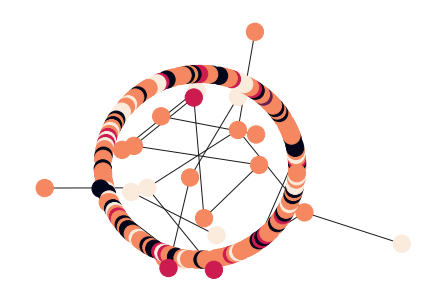

In [19]:
rewired_dataset = module.rewire(dataset, model_indices=[1], threshold=0.4)
rewired_g = to_networkx(rewired_dataset[0]).to_undirected()
nx.draw_kamada_kawai(rewired_g, node_color=data.y, font_color="whitesmoke")
from torch_geometric.utils import homophily
print('homophily:', homophily(rewired_dataset[0].edge_index, rewired_dataset[0].y, method="edge"))
print('validation homophiy:', homophily(get_masked_subgraph_edges(rewired_dataset[0], val_mask), data.y[val_mask], method="node"))
print('edges after rewiring:', rewired_dataset[0].num_edges)

homophily: 0.2998204529285431
torch.Size([183]) torch.Size([59, 59]) torch.Size([2, 112])
validation homophiy: 0.3392857015132904
edges before rewiring: 557


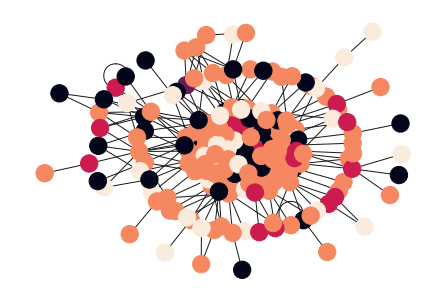

In [20]:
nx.draw_kamada_kawai(g, node_color=data.y, font_color="whitesmoke")
print('homophily:', homophily(data.edge_index, data.y, method="edge"))
print('validation homophiy:', homophily(get_masked_subgraph_edges(data, val_mask), data.y[val_mask], method="edge"))
print('edges before rewiring:', data.num_edges)

In [21]:
def get_sim_matrix(model):
    # output = model().detach()
    # triu_indices = torch.triu_indices(data.num_nodes, data.num_nodes, offset=1)
    # sim = torch.zeros(data.num_nodes, data.num_nodes).index_put((triu_indices[0],triu_indices[1]), output)
    # sim = sim + sim.T
    # return sim
    return model().detach().squeeze()

from models.autoencoders import cosine_sim
def get_fea_sim(x):
    # output = torch.nn.functional.pdist(x, p=1)
    # triu_indices = torch.triu_indices(data.num_nodes, data.num_nodes, offset=1)
    # sim = torch.zeros(data.num_nodes, data.num_nodes).index_put((triu_indices[0],triu_indices[1]), output)
    # sim = sim + sim.T
    # return sim
    return cosine_sim(x).squeeze()

In [22]:
# sim_fea = module.fea_sim_model().detach().triu(diagonal=1)
# sim_str= module.struct_sim_model().detach().triu(diagonal=1)
# sim_str_fea= sim_fea + sim_str
sim_label = create_label_sim_matrix(data, mask=torch.ones(data.num_nodes).bool()).detach().triu(diagonal=1)
sim_label = sim_label + sim_label.T + torch.eye(data.num_nodes, data.num_nodes)

sim_conv = get_sim_matrix(module.conv_sim_model)
sim_fea = get_sim_matrix(module.fea_sim_model)
sim_str = get_sim_matrix(module.struct_sim_model)
sim_low_str = get_sim_matrix(module.low_pass_sim_model)
sim_low_fea = get_sim_matrix(module.low_pass_fea_sim_model)
fea = get_fea_sim(data.x)

In [23]:
print(sim_str.max(), sim_fea.max(), sim_conv.max(), sim_low_str.max(), sim_low_fea.max(), fea.max())

tensor(1.0000) tensor(1.0000) tensor(1.0000) tensor(1.0000) tensor(1.0000) tensor(1.0000)


In [24]:
# sim_fea = sim_fea + torch.eye(data.num_nodes, data.num_nodes)*sim_fea.max()
# sim_str = sim_str + torch.eye(data.num_nodes, data.num_nodes)*sim_str.max()
# sim_conv = sim_conv + torch.eye(data.num_nodes, data.num_nodes)*sim_conv.max()
# sim_low_str = sim_low_str + torch.eye(data.num_nodes, data.num_nodes)*sim_low_str.max() + 1e-14
# sim_low_fea = sim_low_fea + torch.eye(data.num_nodes, data.num_nodes)*sim_low_fea.max() + 1e-14
# fea = fea + torch.eye(data.num_nodes, data.num_nodes)*fea.max() + 1e-14

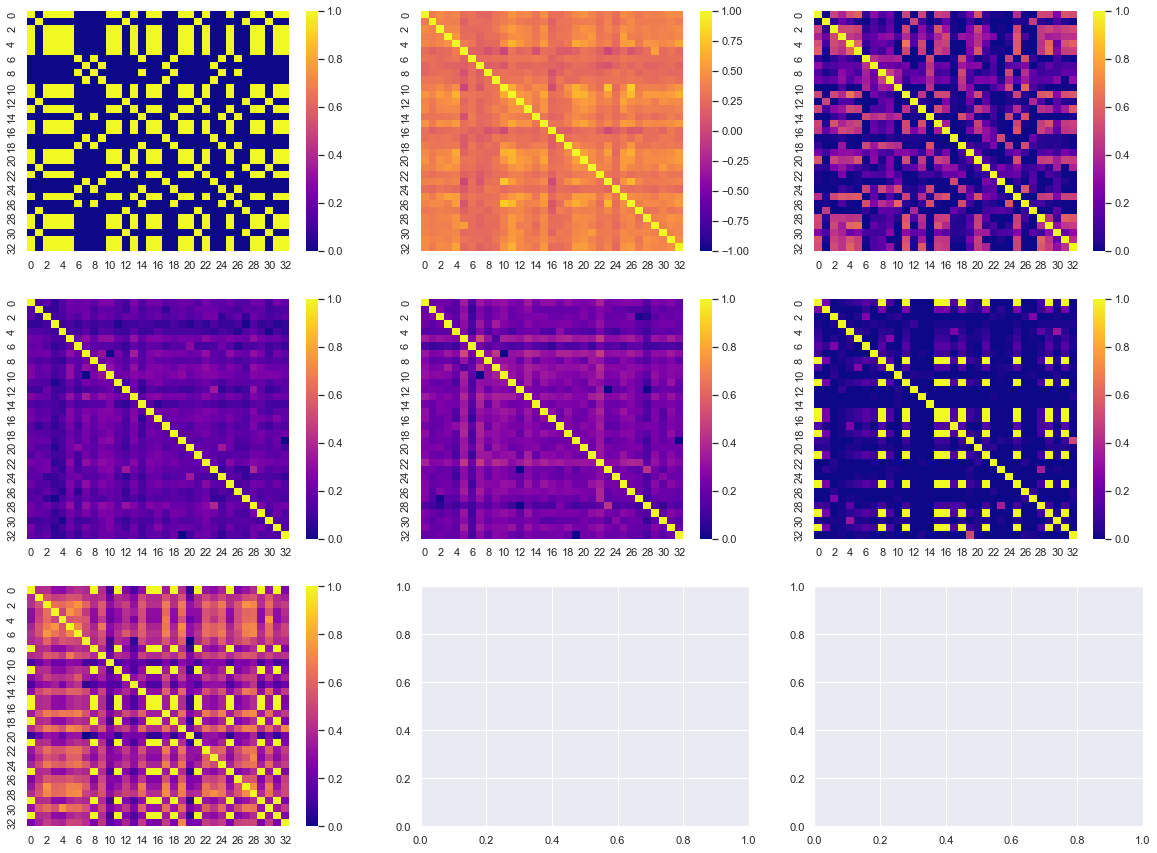

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, PowerNorm, TwoSlopeNorm
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) ) = plt.subplots(3, 3, figsize=(20,15))
index = 150
sns.heatmap(sim_label[index:, index:], ax=ax1, cmap="plasma")
sns.heatmap(fea[index:, index:], ax=ax2, cmap="plasma", vmax=1, vmin=-1)
sns.heatmap(sim_fea[index:, index:], ax=ax3, cmap="plasma", vmax=1, vmin=0)
sns.heatmap(sim_str[index:, index:], ax=ax4, cmap="plasma", vmax=1, vmin=0)
sns.heatmap(sim_conv[index:, index:], ax=ax5, cmap="plasma", vmax=1, vmin=0)
sns.heatmap(sim_low_str[index:, index:], ax=ax6, cmap="plasma", vmax=1, vmin=0)
sns.heatmap(sim_low_fea[index:, index:], ax=ax7, cmap="plasma", vmax=1, vmin=0)
plt.show()

In [91]:
sim_label[:index,:index].count_nonzero()

tensor(3796)

In [92]:
sim_dist = (sim_fea - sim_str).abs().triu(diagonal=1)

In [21]:
ind = sim_dist.argmax()

In [22]:
triu_indices = torch.triu_indices(sim_dist.shape[0],sim_dist.shape[1], offset=1)

triu_values = sim_fea[triu_indices.unbind()]
_, fea_indices = torch.topk(triu_values, k=5000, largest=True)

triu_values = sim_str[triu_indices.unbind()]
_, str_indices = torch.topk(triu_values, k=5000, largest=False)

In [23]:
str_indices = set(str_indices.tolist())
fea_indices = set(fea_indices.tolist())
common = str_indices.intersection(fea_indices)
common
ind = list(common)[0]

In [24]:
i, j = triu_indices[:, ind].tolist()
print(i, j)

89 188


In [25]:
sim_dist[i, j]

tensor(0.5140)

In [26]:
sim_fea[i,j]

tensor(0.5495)

In [27]:
sim_str[i,j]

tensor(0.0355)

In [28]:
sim_conv[i,j]


tensor(0.1634)

89 : tensor(1) 188 : tensor(1)


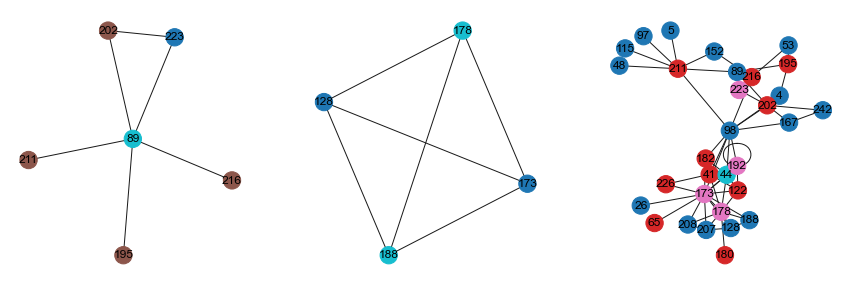

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
nodes = list(g.neighbors(i)) + [i]
labels = data.y[nodes]
nx.draw(nx.ego_graph(g, i), ax=ax1, cmap="tab10", node_color=labels, with_labels=True, font_color="black")
nodes = list(g.neighbors(j)) + [j]
labels = data.y[nodes]
nx.draw(nx.ego_graph(g, j), ax=ax2, cmap="tab10", node_color=labels, with_labels=True, font_color="black")
hops = 2
nodes = list(set(list(nx.single_source_shortest_path_length(g, i, cutoff=hops).keys())+list(nx.single_source_shortest_path_length(g, j, cutoff=hops).keys())))
labels = data.y[nodes]
print(i, ':', data.y[i], j, ':', data.y[j] )
nx.draw(g.subgraph(nodes), ax=ax3, cmap="tab10", node_color=labels, with_labels=True, font_color="black")

89 188


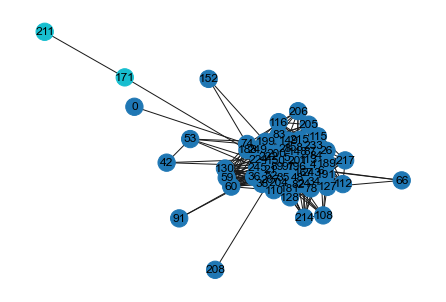

In [30]:
hops = 2
nodes = list(set(list(nx.single_source_shortest_path_length(rewired_g, i, cutoff=hops).keys())+list(nx.single_source_shortest_path_length(rewired_g, j, cutoff=hops).keys())))
labels = data.y[nodes]
print(i, j)
nx.draw(rewired_g.subgraph(nodes), node_color=labels, with_labels=True, font_color="black", cmap="tab10")

In [31]:
import shap
shap.initjs()

def masker(binary_mask, x):
    print(binary_mask.shape, x.shape)
community = create_label_sim_matrix(data, train_mask)

In [32]:
D = module.struct_sim_model.D.view(-1, 21)
D.shape

RuntimeError: shape '[-1, 21]' is invalid for input of size 693011

In [33]:
med = D.median(dim=0)[0].view(1, -1).repeat(D.shape[0], 1)
med.shape

NameError: name 'D' is not defined

In [174]:
def f(x, masks):
    print(masks)

    return module.struct_sim_model(D).view(-1).detach().numpy()

In [29]:
explainer = shap.Explainer(f, med.numpy())

In [30]:
shap_values = explainer(D, batch_size=D.shape[0])

KeyboardInterrupt: 

In [31]:
2243026243/2
med.shape


torch.Size([1, 21])

In [9]:
torch.allclose(D.view(-1, 183, 183).permute(1, 2, 0), module.struct_sim_model.D)
module.struct_sim_model.D.shape

NameError: name 'D' is not defined

In [56]:
explainer

In [151]:
sub = community[train_mask,:][:, train_mask]

In [12]:
community.shape

NameError: name 'community' is not defined

<AxesSubplot:>

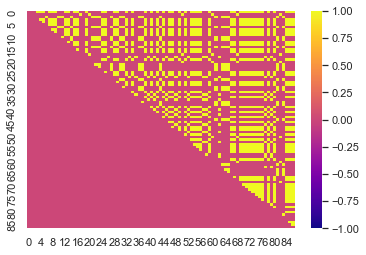

In [153]:

sns.heatmap(sub, cmap="plasma", vmax=1, vmin=-1)

In [150]:
sub.shape

AttributeError: 'torch.Size' object has no attribute 'shape'

In [117]:
model = module.struct_sim_model
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

ig = IntegratedGradients(model)

In [118]:
# input = torch.stack([torch.ones(1, 1, module.struct_sim_model.D.shape[-1]),torch.zeros(1, 1, module.struct_sim_model.D.shape[-1]) ], dim=0)
# attributions, delta = ig.attribute(input, target=[(1, 1), (0, 0)], return_convergence_delta=True, internal_batch_size=50)
input = torch.ones(1, 1, 1, model.D.shape[-1])
attributions, delta = ig.attribute(input, target=[(1, 1)], return_convergence_delta=True, internal_batch_size=50)

In [119]:
import numpy as np
# attributions = attributions.squeeze()
ig_attr_test_sum = attributions.detach().numpy().sum(0).squeeze()
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=2)

<BarContainer object of 11 artists>

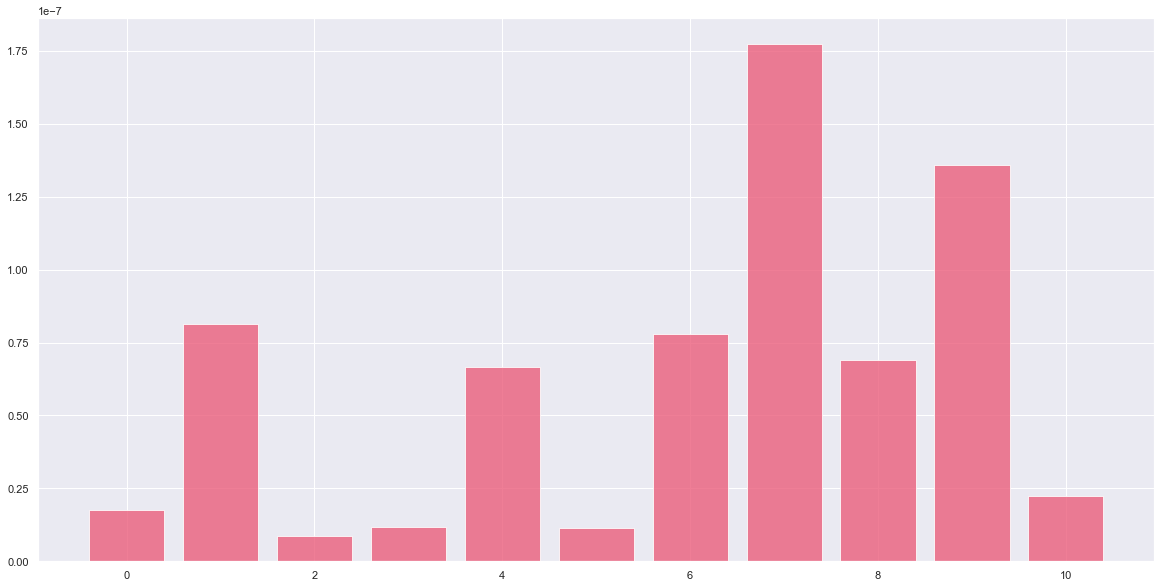

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
x_axis_data = np.arange(input.shape[-1])
plt.bar(x_axis_data, np.abs(ig_attr_test_sum), align='center', alpha=0.8, color='#eb5e7c')

In [46]:
ig_attr_test_norm_sum

array([-0.38555399, -0.07727566, -0.18442441,  0.00914536, -0.00664821,
       -0.19256101, -0.39431548, -0.68416106, -0.28380568, -0.24008202,
        0.11140268])

In [199]:
ig_attr_test_norm_sum[[3,4,30,38]]

array([0.04995228, 0.09048918, 0.1012268 , 0.11755451])

In [200]:
torch.tensor([3,4,30,38])*0.05

tensor([0.1500, 0.2000, 1.5000, 1.9000])